* Omkar Thorve
* 24070149016
* M.Tech AIML

In [1]:
import os
import tarfile
import torch
import numpy as np

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
from torch.nn import AvgPool2d
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary
from torchsummary import summary

from scipy.io import loadmat

In [2]:

root='http://ufldl.stanford.edu/housenumbers/'

transform = transforms.Compose([
                                transforms.CenterCrop((28, 28)),
                                transforms.ToTensor(),
                                #transforms.Normalize([0.5,],[0.5,])
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                                ])

train = torchvision.datasets.SVHN(root, split='train', transform=transform, target_transform=None, download=True)

train_dl = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

test_vi = torchvision.datasets.SVHN(root, split='test', transform=transforms.ToTensor(),download=True)
test_vii = torch.utils.data.DataLoader(test_vi, batch_size=128, shuffle=True)

test = torchvision.datasets.SVHN(root, split='test', transform=transform, target_transform=None, download=True)

test_dl = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

images_train, labels_train = next(iter(train_dl))
images_test, labels_test = next(iter(test_dl))
images_test_vi, labels_test_vi = next(iter(test_vi))

print("Shape of train inputs: ", images_train.shape, "; Shape of train labels: ", labels_train.shape)
print("Shape of test inputs: ",images_test.shape, "; Shape of test inputs: ", labels_test.shape)
print("Batch size = 128")

100%|██████████| 182M/182M [00:04<00:00, 45.2MB/s]


100%|██████████| 64.3M/64.3M [00:01<00:00, 34.3MB/s]


Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Shape of train inputs:  torch.Size([128, 3, 28, 28]) ; Shape of train labels:  torch.Size([128])
Shape of test inputs:  torch.Size([128, 3, 28, 28]) ; Shape of test inputs:  torch.Size([128])
Batch size = 128


In [3]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)

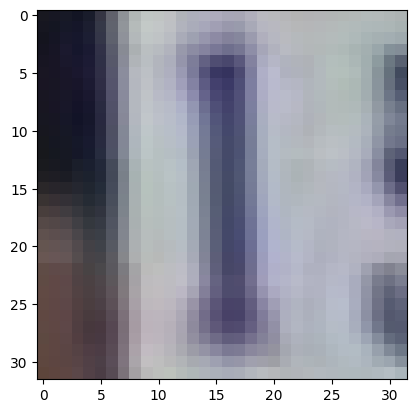

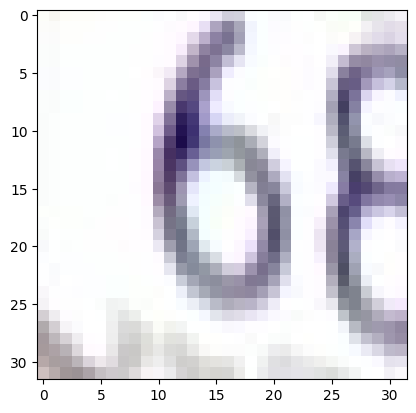

In [5]:
dataiter = iter(test_vii)
images, labels = next(dataiter)
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

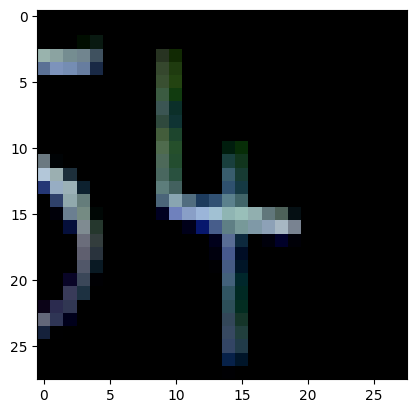

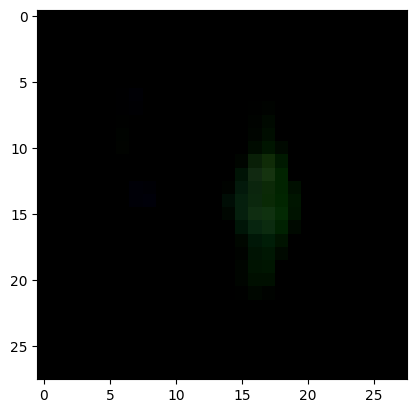

In [9]:
dataiter = iter(test_dl)
images, labels = next(dataiter)
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

In [10]:
img, label = train[0]
print(img.shape, label)
img

torch.Size([3, 28, 28]) 1


tensor([[[-0.8745, -0.7647, -0.4980,  ..., -0.7412, -0.8039, -0.8196],
         [-0.8196, -0.8196, -0.5373,  ..., -0.6471, -0.5294, -0.6157],
         [-0.8275, -0.8588, -0.5922,  ..., -0.4745, -0.3569, -0.4039],
         ...,
         [-0.3569, -0.4431, -0.8196,  ..., -0.3333, -0.2078, -0.2000],
         [-0.3961, -0.4275, -0.6863,  ..., -0.2078, -0.1922, -0.1765],
         [-0.3569, -0.3725, -0.5137,  ..., -0.1765, -0.1843, -0.1843]],

        [[-0.8667, -0.7490, -0.5137,  ..., -0.8353, -0.7569, -0.7725],
         [-0.8588, -0.8039, -0.5451,  ..., -0.6314, -0.5843, -0.6627],
         [-0.8353, -0.8353, -0.5608,  ..., -0.4431, -0.4275, -0.4667],
         ...,
         [-0.4039, -0.4980, -0.8353,  ..., -0.2941, -0.2392, -0.2078],
         [-0.3647, -0.4196, -0.7020,  ..., -0.2314, -0.2000, -0.1843],
         [-0.3804, -0.3961, -0.5059,  ..., -0.1843, -0.1843, -0.1843]],

        [[-0.8196, -0.7647, -0.5765,  ..., -0.6471, -0.6941, -0.6471],
         [-0.8039, -0.8118, -0.5922,  ..., -0

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

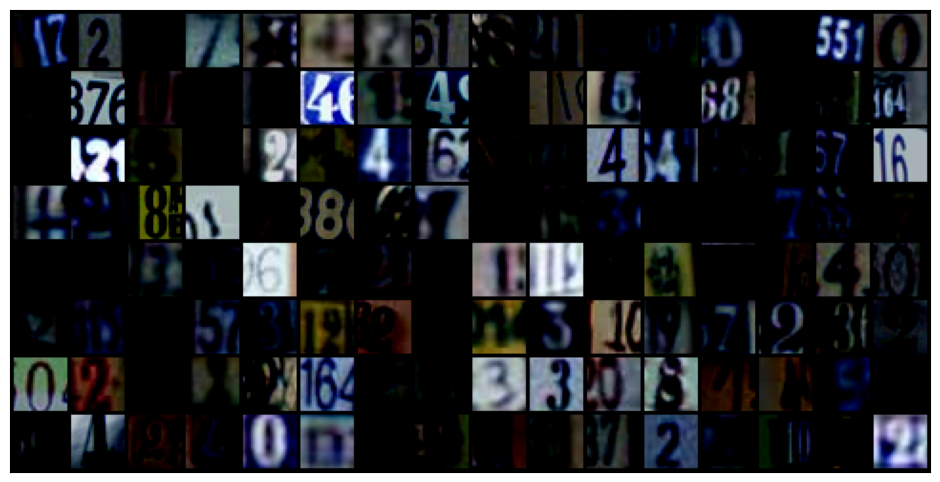

In [12]:

show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device


device(type='cuda')

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [19]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [20]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
input_size = 2352
num_classes = 10

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [22]:
model5 = to_device(ResNet(3, 10), device)
model5

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [23]:

summary(model5, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,792
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
       BatchNorm2d-5          [-1, 128, 28, 28]             256
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]         147,584
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
           Conv2d-11          [-1, 128, 14, 14]         147,584
      BatchNorm2d-12          [-1, 128, 14, 14]             256
             ReLU-13          [-1, 128, 14, 14]               0
           Conv2d-14          [-1, 256,

In [24]:
print(sum(p.numel() for p in model5.parameters()))
print(sum(p.numel() for p in model5.parameters() if p.requires_grad))

6575370
6575370


In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(test_dl, device)

In [28]:
history5 = [evaluate(model5, val_dl)]
history5

[{'val_loss': 2.305161714553833, 'val_acc': 0.06376378983259201}]

In [29]:
grad_clip = 0.1
weight_decay = 1e-4

In [30]:
%%time
history5 = fit_one_cycle(num_epochs, lr, model5, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 0.7682, val_loss: 0.4158, val_acc: 0.8709
Epoch [1], train_loss: 0.3085, val_loss: 0.3431, val_acc: 0.8984
Epoch [2], train_loss: 0.2425, val_loss: 0.2446, val_acc: 0.9293
Epoch [3], train_loss: 0.1930, val_loss: 0.2265, val_acc: 0.9367
Epoch [4], train_loss: 0.1480, val_loss: 0.2443, val_acc: 0.9299
Epoch [5], train_loss: 0.1082, val_loss: 0.2224, val_acc: 0.9405
Epoch [6], train_loss: 0.0608, val_loss: 0.1940, val_acc: 0.9511
Epoch [7], train_loss: 0.0214, val_loss: 0.1879, val_acc: 0.9544
Epoch [8], train_loss: 0.0043, val_loss: 0.1797, val_acc: 0.9580
Epoch [9], train_loss: 0.0019, val_loss: 0.1784, val_acc: 0.9588
CPU times: user 6min 24s, sys: 1.28 s, total: 6min 26s
Wall time: 6min 31s


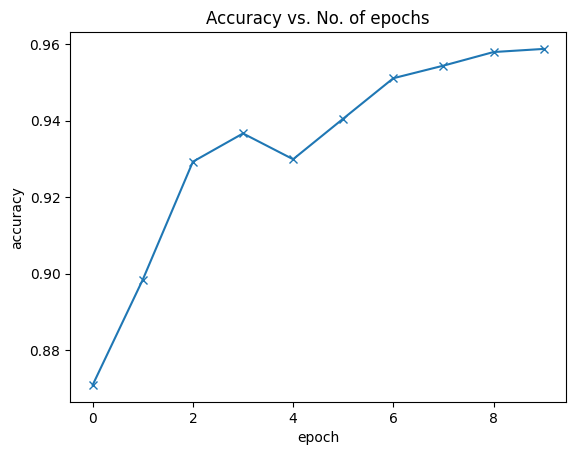

In [31]:
plot_accuracies(history5)

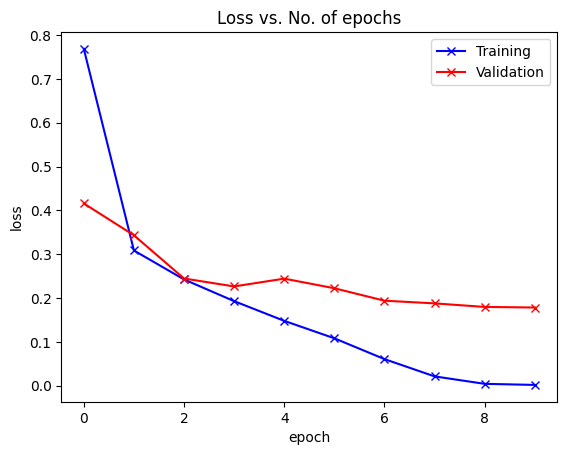

In [32]:
plot_losses(history5)

In [33]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

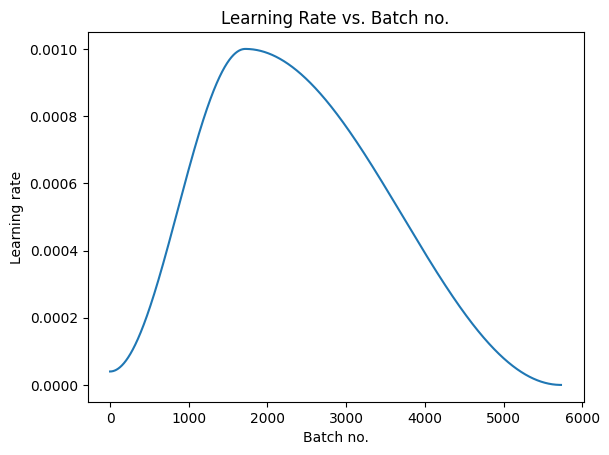

In [34]:
plot_lrs(history5)

In [35]:
torch.save(model5.state_dict(), 'svhn_resnet9.pth')

In [36]:
result5 = evaluate(model5, val_dl)
print(result5)

{'val_loss': 0.1788986474275589, 'val_acc': 0.9586014151573181}
